## Neural Network Classification 

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples 
n_samples = 1000

# create circles

X,y = make_circles(n_samples, 
                   noise=0.03,
                   random_state=42)

In [3]:
print(f"The first 5 samples of X:\n {X[:5]}")
print(f"The firt 5 values of y:\n {y[:5]}")

The first 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
The firt 5 values of y:
 [1 1 1 1 0]


In [4]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1], "label": y})

In [5]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


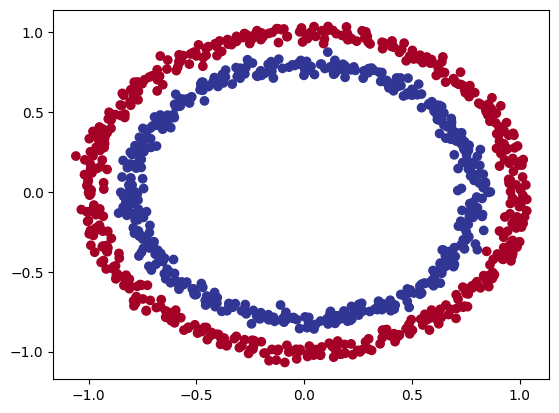

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

## 1.1 check the shape of the data

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

## 1.2 Turn the data into tensors and create train test splits

In [8]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.dtype, y.dtype

(torch.float32, torch.float32)

In [9]:
# split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [11]:
from torch import nn

### Create a subclass of nn.Module

In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # create a neural network using the nn.Linear layer
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    # forward propagation
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0()
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

### Recreate the neural network using the nn.Sequential

In [13]:
# Let's replicate the model
model_0 = nn.Sequential(
    nn.Linear(in_features=2,
              out_features=5),
    nn.Linear(in_features=5, 
              out_features=1)
    
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6157,  0.1292],
                      [ 0.0573, -0.5477],
                      [-0.4068, -0.3664],
                      [-0.5373, -0.0806],
                      [ 0.5834, -0.3841]])),
             ('0.bias', tensor([-0.3393,  0.6925,  0.5233, -0.0814, -0.7011])),
             ('1.weight',
              tensor([[-0.0040,  0.1460, -0.1259,  0.1240,  0.3345]])),
             ('1.bias', tensor([0.2176]))])

What we have here is a random neural network with parameters. This parameters are random, no training has taken place yet. When we train this network with data, through the optimizer, it will adjust the parameters to the one that best captures the distribution and pattern in the data.

In [15]:
# Make predictions
untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"The first 5 predictions: \n {untrained_preds[:5]}")
print(f"\n First 5 labels: \n {y_test[:5]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])
The first 5 predictions: 
 tensor([[-0.1799],
        [-0.1534],
        [-0.0699],
        [-0.2118],
        [ 0.2148]], grad_fn=<SliceBackward0>)

 First 5 labels: 
 tensor([1., 0., 1., 0., 1.])


In [16]:
# Setup a loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

 Our model outputs are going to be raw **logit**

 We need to convert these **logits** into **probabilities**. This can be done through the use of an activation function like sigmoid or softmax which is good for multiclass classification.

Logits are raw outputs of the model without being passed through any activation function.

 Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or using the argmax()

In [17]:
# View the first 5 output of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
y_logits

tensor([[-0.1799],
        [-0.1534],
        [-0.0699],
        [-0.2118],
        [ 0.2148]])

In [18]:
# Use the sigmoid activation function for our model logits to turn them into predictions probabilities
y_pred_prob  = torch.sigmoid(y_logits)
y_pred_prob


tensor([[0.4551],
        [0.4617],
        [0.4825],
        [0.4472],
        [0.5535]])

The result above shows the probabilty predictions for the class. The values tells us how likely our model tells us that the output belongs to the class labeled 1. Let's say we set a threshold of **0.5**, this would mean anything above it will be taken as 1 and below it taken as zero.

In [19]:
# let's check our class predictions and compare with ground truth for the first few entries
torch.round(y_pred_prob), y_test[:5]

(tensor([[0.],
         [0.],
         [0.],
         [0.],
         [1.]]),
 tensor([1., 0., 1., 0., 1.]))

In [20]:
# Find all the predicted labels
y_preds = torch.round(torch.sigmoid(model_0(X_test)))
# model_0(X_test) -- gives the pred logits
# torch.sigmoid() -- gives the probability prediction
# torch.round() -- gives the class prediction

## Building a training anf testing loop

In [21]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Build training and evaluation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # Forward Propagation
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate the Loss/accuracy
    loss = loss_fn(y_logits, 
                   y_train)
    
    acc = accuracy_fn(y_true=y_train,
                      y_pred= y_pred)
    
    # optimizer
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Gradient Descent
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print the performance
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69711, Accuracy: 50.50% | Test Loss: 0.69452, Test acc: 48.50%
Epoch: 10 | Loss: 0.69625, Accuracy: 50.25% | Test Loss: 0.69401, Test acc: 48.50%
Epoch: 20 | Loss: 0.69560, Accuracy: 50.38% | Test Loss: 0.69363, Test acc: 48.50%
Epoch: 30 | Loss: 0.69510, Accuracy: 50.75% | Test Loss: 0.69336, Test acc: 48.50%
Epoch: 40 | Loss: 0.69471, Accuracy: 50.75% | Test Loss: 0.69317, Test acc: 49.00%
Epoch: 50 | Loss: 0.69441, Accuracy: 50.25% | Test Loss: 0.69305, Test acc: 49.00%
Epoch: 60 | Loss: 0.69416, Accuracy: 50.38% | Test Loss: 0.69296, Test acc: 49.00%
Epoch: 70 | Loss: 0.69397, Accuracy: 50.38% | Test Loss: 0.69292, Test acc: 49.00%
Epoch: 80 | Loss: 0.69381, Accuracy: 50.25% | Test Loss: 0.69290, Test acc: 48.50%
Epoch: 90 | Loss: 0.69368, Accuracy: 50.25% | Test Loss: 0.69290, Test acc: 48.50%


In [22]:
import requests
from pathlib import Path

# Download helper functions from repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skip download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skip download


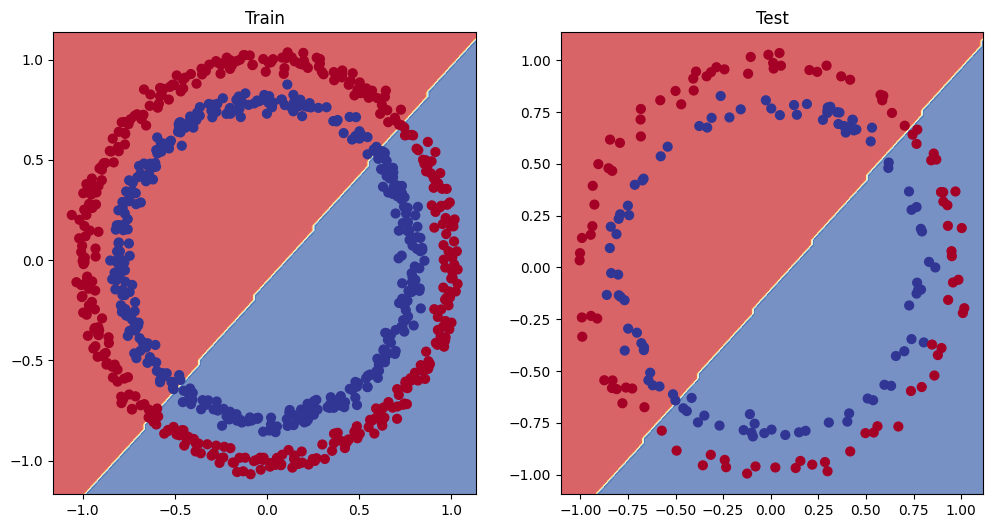

In [23]:
# Plot decision boundary of the model 
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

From the visualization above, we can see that the model doesn't capture the pattern well. it's a simple neural network with linear layers. that's why it tries to draw a straight line through it when in the real sense it's a circle.

### Ways to improve the training outcomes

* Add more layers
* Add more hidden units
* Add more epochs (but in this case it didn't work)
* Change the activation function
* Change the learning rate

These are changes we make from the model's perspective. Getting more data can help in some cases but not always. what we're simply doing here is tuning the **Hyperparameters**

#### Below is my experiment. let's see how it goes and if there's a need, we can make some other changes to it.

In [24]:
# New Neural Network Architecture
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    #nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1)
)
model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
# Setup a loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup an optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.01)

# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [26]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Build training and evaluation loop
for epoch in range(epochs):
    # Training
    model.train()

    # Forward Propagation
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate the Loss/accuracy
    loss = loss_fn(y_logits, 
                   y_train)
    
    acc = accuracy_fn(y_true=y_train,
                      y_pred= y_pred)
    
    # optimizer
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Gradient Descent
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # sigmoid because we're working with a binary classification

        # calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print the performance
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69833, Accuracy: 50.00% | Test Loss: 0.69674, Test acc: 47.50%
Epoch: 10 | Loss: 0.68826, Accuracy: 60.38% | Test Loss: 0.68793, Test acc: 57.50%
Epoch: 20 | Loss: 0.67865, Accuracy: 57.63% | Test Loss: 0.67717, Test acc: 57.00%
Epoch: 30 | Loss: 0.66045, Accuracy: 58.75% | Test Loss: 0.66615, Test acc: 59.00%
Epoch: 40 | Loss: 0.62854, Accuracy: 65.50% | Test Loss: 0.63680, Test acc: 63.00%
Epoch: 50 | Loss: 0.56971, Accuracy: 91.12% | Test Loss: 0.57575, Test acc: 90.00%
Epoch: 60 | Loss: 0.47839, Accuracy: 96.38% | Test Loss: 0.49913, Test acc: 93.50%
Epoch: 70 | Loss: 0.36200, Accuracy: 99.12% | Test Loss: 0.40085, Test acc: 96.00%
Epoch: 80 | Loss: 0.25201, Accuracy: 99.38% | Test Loss: 0.29281, Test acc: 99.00%
Epoch: 90 | Loss: 0.17579, Accuracy: 99.88% | Test Loss: 0.21491, Test acc: 98.50%


### What was done new in the new architecture
* Added an extra layer
* Added more units. moved from 5 to 10 hidden units
* Added an activation function to de-linearize the relationship
* Changed the learning rate

In result, we have a better model that has a test accuracy of 98% at the 90th epoch

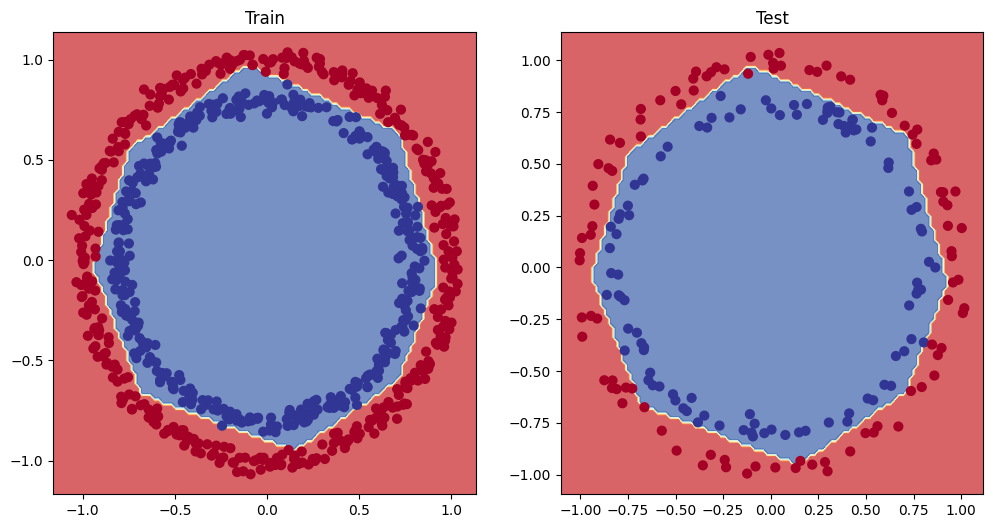

In [27]:
# Plot decision boundary of the model 
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

From the output of the decision boundary, we can see power of the ReLu activation function. This is so because our data has a non linear relationship. Without including the activation function, our model will fail to capture the relationship always thinking it's a linear when it is not.